In [1]:
!pip install opendatasets

----
## Loading Pneumonia Dataset from kaggle

In [2]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fatemeh.fe76it@gmail.com
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:18<00:00, 136MB/s]


In [3]:
import os
os.listdir()

['.config', 'chest-xray-pneumonia', 'sample_data']

In [4]:
os.chdir("chest-xray-pneumonia")
os.listdir()

['chest_xray']

In [5]:
# For local system
path = 'chest_xray'

train_NORAML_data = os.listdir(path+'/train/NORMAL')
train_PNEUMONIA_data = os.listdir(path+'/train/PNEUMONIA')
test_NORAML_data = os.listdir(path+'/test/NORMAL')
test_PNEUMONIA_data = os.listdir(path+'/test/PNEUMONIA')

print(f'number of images in train_NORAML_data : {len(train_NORAML_data)}')
print(f'number of images in train_PNEUMONIA_data : {len(train_PNEUMONIA_data)}')
print(f'number of images in test_NORAML_data : {len(test_NORAML_data)}')
print(f'number of images in test_PNEUMONIA_data : {len(test_PNEUMONIA_data)}')

number of images in train_NORAML_data : 1341
number of images in train_PNEUMONIA_data : 3875
number of images in test_NORAML_data : 234
number of images in test_PNEUMONIA_data : 390


----
## Creating Data Generators

In [16]:
base_dir = 'chest_xray/chest_xray'

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'test')

# Directory with training PNEUMONIA pictures
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Directory with training NORMAL pictures
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# Directory with validation PNEUMONIA pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

# Directory with validation NORMAL pictures
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 10,
                                                    class_mode = 'binary',
                                                    target_size = (256, 256))

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 10,
                                                          class_mode  = 'binary',
                                                          target_size = (256, 256))

print('okay!')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
okay!


----
## Loaing VGG19 model

In [26]:
import tensorflow as tf

base_model = tf.keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


----
## Creating the whole model for fine tuning

In [27]:
#Fine-Tuning
base_model.trainable = True

# Create new model on top
inputs = tf.keras.Input(shape=(256, 256, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(1024, activation = 'relu', name = 'FC1')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation = 'relu', name = 'FC2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation = 'relu', name = 'FC3')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'classifier_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 vgg19 (Functional)          (None, 8, 8, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_6 (Dropout)         (None, 512)               0         Y          
                                                                            
 FC1 (Dense)                 (None, 1024)              5253

In [28]:
op = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

model.compile(
	# specify the loss function to use during training
	loss='binary_crossentropy',
	# specify the optimizer algorithm to use during training
	optimizer=op ,
	# specify the evaluation metrics to use during training
	metrics=['accuracy']
)


In [29]:
import time

start_time = time.time()

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
						validation_steps = 10,
						steps_per_epoch = 100,
            epochs = 50)

end_time = time.time()
training_time = end_time - start_time
print("Total Training Time: {} seconds".format(training_time))

Epoch 1/50
100/100 [==============================] - 28s 225ms/step - loss: 0.5960 - accuracy: 0.7000 - val_loss: 0.7331 - val_accuracy: 0.5800
Epoch 2/50
100/100 [==============================] - 22s 216ms/step - loss: 0.5510 - accuracy: 0.7340 - val_loss: 0.9088 - val_accuracy: 0.5400
Epoch 3/50
100/100 [==============================] - 21s 212ms/step - loss: 0.4788 - accuracy: 0.7651 - val_loss: 0.6287 - val_accuracy: 0.6000
Epoch 4/50
100/100 [==============================] - 22s 217ms/step - loss: 0.4063 - accuracy: 0.7900 - val_loss: 0.7273 - val_accuracy: 0.7300
Epoch 5/50
100/100 [==============================] - 21s 212ms/step - loss: 0.3761 - accuracy: 0.7850 - val_loss: 0.3858 - val_accuracy: 0.8400
Epoch 6/50
100/100 [==============================] - 22s 218ms/step - loss: 0.3731 - accuracy: 0.8040 - val_loss: 0.5011 - val_accuracy: 0.7700
Epoch 7/50
100/100 [==============================] - 22s 218ms/step - loss: 0.3451 - accuracy: 0.8353 - val_loss: 0.4877 - val_ac

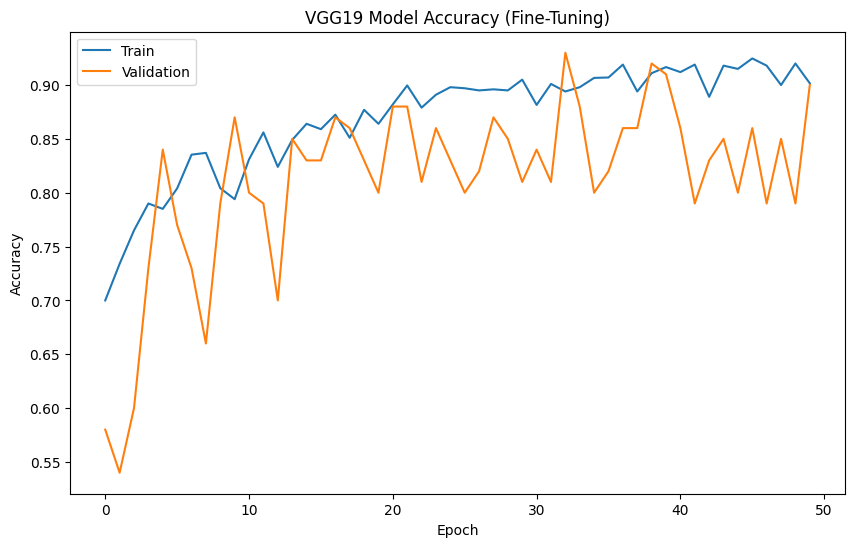

In [30]:
import matplotlib.pyplot as plt


# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG19 Model Accuracy (Fine-Tuning)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the ground truth labels and predictions
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int)
y_true = validation_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Generate classification report with precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_true, y_pred))

63/63 [==============================] - 5s 75ms/step
Confusion Matrix:
[[ 78 156]
 [152 238]]
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.33      0.34       234
           1       0.60      0.61      0.61       390

    accuracy                           0.51       624
   macro avg       0.47      0.47      0.47       624
weighted avg       0.50      0.51      0.51       624



In [32]:
start_time = time.time()

# Perform inference on some sample data
sample_data = validation_generator.next()
predictions = model.predict(sample_data[0])

end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {} seconds".format(inference_time))

1/1 [==============================] - 0s 194ms/step
Inference Time: 0.3659062385559082 seconds
